In [1]:
# %load defaults.ipy
from numpy import *
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 600
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import os
import xml.dom.minidom
import sys
sys.path.append("../python")

import plot_info
from plot_info import showAndSave
plot_info.set_notebook_name("BV_experiments.ipynb")


print("STATISTICAL_BV={}".format(plot_info.get_environment("STATISTICAL_BV", [])))

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
STATISTICAL_BV=/cluster/project/sam/klye/systemspaperdata


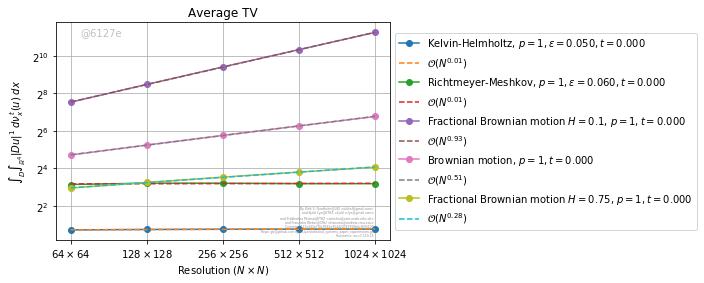

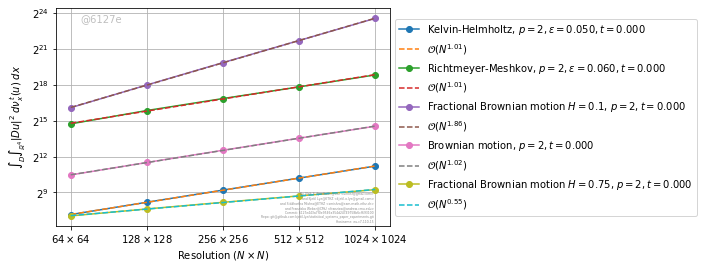

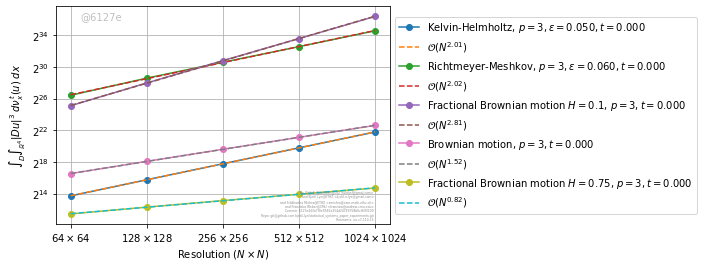

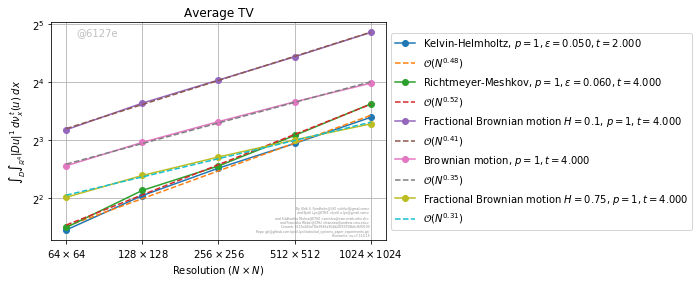

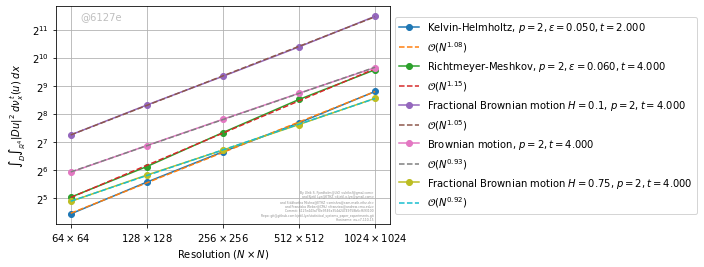

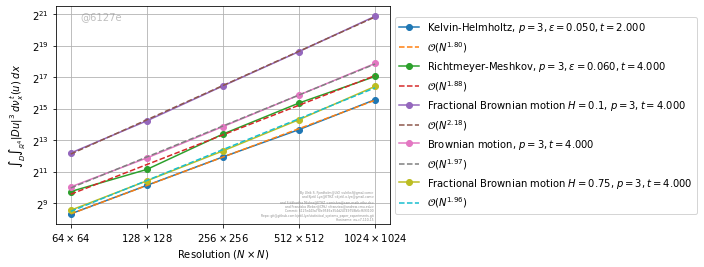

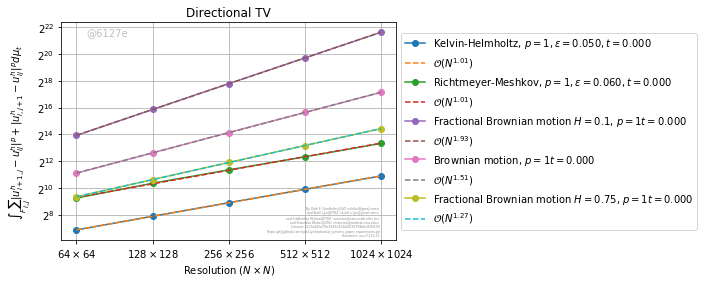

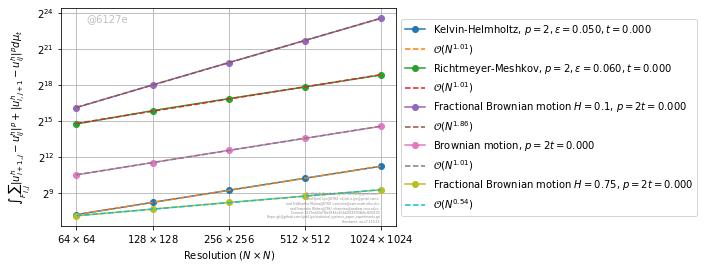

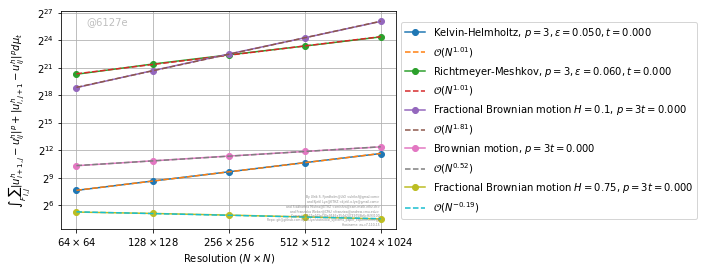

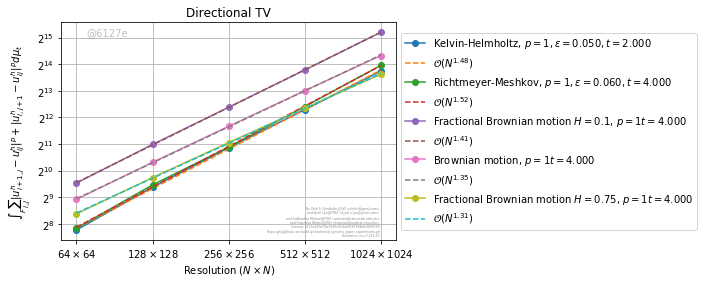

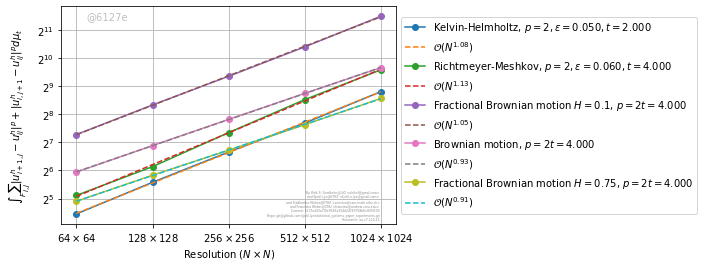

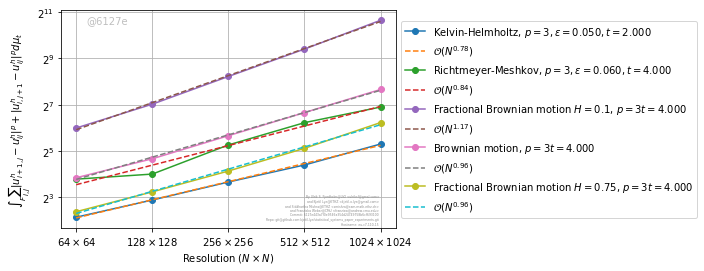

In [2]:
class BV(object):
    def __init__(self):
        self.basenames = {'kh' : 'bv/kh/kelvinhelmholtz_{perturbation}_{resolution}/kh_bv_{p}_{time}.nc',
                         'rm' : 'bv/rm/richtmeyermeshkov_{perturbation}_{resolution}/rm_bv_{p}_{time}.nc',
                          #'cloudshock': 'bv/cloudshock/cloudshock_{perturbation}_{resolution}/cloudshock_bv_{p}_{time}.nc',
                          'fbm05': 'bv/fbm/euler_brownian_0.5_{resolution}/eulerbrownian_bv_{p}_{time}.nc',
                          'fbm01': 'bv/fbm/euler_brownian_0.1_{resolution}/eulerbrownian_bv_{p}_{time}.nc',
                          'fbm075': 'bv/fbm/euler_brownian_0.75_{resolution}/eulerbrownian_bv_{p}_{time}.nc',
                          
                         }
        
        
        self.basenames_direction = {'kh' : 'bv/kh/kelvinhelmholtz_{perturbation}_{resolution}/kh_bv_{d}_{p}_{time}.nc',
                         'rm' : 'bv/rm/richtmeyermeshkov_{perturbation}_{resolution}/rm_bv_{d}_{p}_{time}.nc',
                           #         'cloudshock': 'bv/cloudshock/cloudshock_{perturbation}_{resolution}/cloudshock_bv_{p}_{time}.nc',
                          'fbm05': 'bv/fbm/euler_brownian_0.5_{resolution}/eulerbrownian_bv_{d}_{p}_{time}.nc',
                          'fbm01': 'bv/fbm/euler_brownian_0.1_{resolution}/eulerbrownian_bv_{d}_{p}_{time}.nc',
                          'fbm075': 'bv/fbm/euler_brownian_0.75_{resolution}/eulerbrownian_bv_{d}_{p}_{time}.nc',
                          }
        self.variables = ['rho', 'mx', 'my', 'E']
    def getBV(self, name, perturbation=0.1, resolution=128, time=0, p=1):
        filename = self.basenames[name].format(perturbation=perturbation, resolution=resolution, time=time, p=p)
        basepath = plot_info.get_environment("STATISTICAL_BV", [filename])
        
        with netCDF4.Dataset(os.path.join(basepath, filename)) as f:
            bv = 0
            for v in self.variables:
                d = f.variables[v][0,0,0]
                bv += d/(len(self.variables)*float(resolution)**(2-p))
            return bv
        
    def getBV_direction(self, name, perturbation=0.1, resolution=128, time=0, p=1):
        bv = 0
        for d in ['x','y']:
            filename = self.basenames_direction[name].format(perturbation=perturbation, resolution=resolution, time=time, p=p,d=d)
            basepath = plot_info.get_environment("STATISTICAL_BV", [filename])
            with netCDF4.Dataset(os.path.join(basepath, filename)) as f:
                
                for v in self.variables:
                    d = f.variables[v][0,0,0]
                    bv += d/(len(self.variables))
        return bv
    
    
    def getPerturbations(self, name):
        if name == 'kh':
            return [0.05]
        elif name == 'rm':
            return [ 0.06]
        elif name == 'cloudshock':
            return [0.075]
        elif name == 'fbm01':
            return [0.1]
        elif name == 'fbm05':
            return [0.5]
        elif name == 'fbm075':
            return [0.75]
            #return [0.05,0.01]
        
    def getTimes(self, name):
        if name == 'kh':
            times = {0:0,10:2}
            #for t in range(0,11):
            #    times[t] = 2.0/10.*t
            return times
        elif name == 'rm':
            times = {0:0,10:4}
            #for t in range(0,11):
            #    times[t] = 4.0/10.*t
            return times
        elif name == 'cloudshock':
            return {0:0,10:0.06}
        elif name == 'fbm01':
            return {0:0,10:4}
        elif name == 'fbm05':
            return {0:0,10:4}
        elif name == 'fbm075':
            return {0:0,10:4}
        
        
        
    def getResolutions(self, name):
        return [64,128,256,512,1024]
    
    def getName(self, name):
        if name =='kh':
            return 'Kelvin-Helmholtz'
        elif name == 'rm':
            return 'Richtmeyer-Meshkov'
        elif name == 'cloudshock':
            return 'Cloudshock'
        elif name == 'fbm01':
            return 'Fractional Brownian motion $H=0.1$'
        elif name == 'fbm05':
            return 'Brownian motion'
        elif name == 'fbm075':
            return 'Fractional Brownian motion $H=0.75$'
        

bv = BV()


def plotTime(name):
    bv = BV()
    for r in bv.getResolutions(name):
        for p in [1,2,3]:
            for pert in bv.getPerturbations(name):
                times = bv.getTimes(name)
                bvs = []
                T = []
                for t in times.keys():
                    bvs.append(bv.getBV(name, perturbation=pert, p=p,time=t, resolution=r))
                    T.append(times[t])
                plt.plot(T, bvs, '-o',label='$p=%d, \epsilon=%.3f$' % (p,pert))
            plt.xlabel('$t$')
            plt.ylabel('$\\int_{D}\\int_{\\mathbb{R}^4}|Du|^{%d}\;d\\nu^{t}_x(u)\;dx$' % p)
            if p == 1:
                plt.title('Average TV for %s with $N_x=M=%d$' % (bv.getName(name), r))
            else:
                plt.title('%s $N_x=M=%d$' % (bv.getName(name), r))
            plt.legend()
            plt.grid('on')
            showAndSave('bv_time_{p}_{r}_{name}'.format(p=p,r=r,name=name))
            
def plotScaling(resolution, bv):
    poly = polyfit(log(resolution), log(bv),1)
    plt.loglog(resolution, exp(poly[1])*resolution**poly[0], '--',label='$\\mathcal{O}(N^{%.2f})$' % poly[0], basex=2, basey=2)
def plotResolution(names):
    if type(names) == str:
        names = [names]
    
    bv = BV()
    
    for t in [0,10]:
        for p in [1,2,3]:
       
            for name in names:
                times = bv.getTimes(name)
                pert = bv.getPerturbations(name)[0]
        
            
                plt.figure(t*3+p-1)
                
                bvs = []
                R = []
                for r in bv.getResolutions(name):            
                    bvs.append(bv.getBV(name, perturbation=pert, p=p,time=t, resolution=r))
                    R.append(r)
                if 'fbm' not in name:
                    label = '%s, $p=%d, \epsilon=%.3f, t=%.3f$' % (bv.getName(name), p,pert,times[t])
                else:
                    label = '%s, $p=%d, t=%.3f$' % (bv.getName(name), p,times[t])
                    
                
                plt.loglog(R, bvs, '-o',label=label, basex=2, basey=2)
                plotScaling(R, bvs)
                
                plt.xlabel('Resolution ($N\\times N$)')
                plt.ylabel('$\\int_{D}\\int_{\\mathbb{R}^4}|Du|^{%d}\;d\\nu^{t}_x(u)\;dx$' % p)
                if p == 1:
                    plt.title('Average TV')
                
                #plt.legend()
            plt.grid('on')
            plt.xticks(R, ['${r} \\times {r}$'.format(r=r) for r in R])
    
            ax = plt.gca()
            #lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plot_info.legendLeft()
            showAndSave('new_bv_res_{p}_{t}'.format(pert=pert,t=t,p=p,r=r,name=name))
                    
                
def plotTimeDirection(name):
    bv = BV()
    for r in bv.getResolutions(name):
        for p in [1,2,3]:
            for pert in bv.getPerturbations(name):
                times = bv.getTimes(name)
                bvs = []
                T = []
                for t in times.keys():
                    bvs.append(bv.getBV_direction(name, perturbation=pert, p=p,time=t, resolution=r))
                    T.append(times[t])
                plt.plot(T, bvs, '-o',label='$p=%d, \epsilon=%.3f$' % (p,pert))
            plt.xlabel('$t$')
            plt.ylabel('$\\int_{F} \\sum_{i,j} |u^h_{i+1,j}-u^h_{ij}|^p + |u^h_{i,j+1} - u^h_{ij}|^p d\\mu_t $')
            if p == 1:
                plt.title('Average TV for %s with $N_x=M=%d$' % (bv.getName(name), r))
            else:
                plt.title('%s $N_x=M=%d$' % (bv.getName(name), r))
            plt.legend()
            plt.grid('on')
            showAndSave('new_bv_time_dir_{p}_{r}_{name}'.format(p=p,r=r,name=name))
            
def plotResolutionDirection(names):
    if type(names) == str:
        names = [names]
    
    bv = BV()
    
    
        
    
    for t in [0,10]:
           
       
        for p in [1,2,3]:
            for name in names:
                pert = bv.getPerturbations(name)[0]
                times = bv.getTimes(name)
                plt.figure(t*3+p-1)
                
                bvs = []
                R = []
                for r in bv.getResolutions(name):            
                    bvs.append(bv.getBV_direction(name, perturbation=pert, p=p,time=t, resolution=r))
                    R.append(r)
                if 'fbm' not in name:
                    label = '%s, $p=%d, \epsilon=%.3f, t=%.3f$' % (bv.getName(name), p,pert,times[t])
                else:
                    label = '%s, $p=%d t=%.3f$' % (bv.getName(name), p,times[t])
                    
                
                plt.loglog(R, bvs, '-o',label=label, basex=2, basey=2)
                plotScaling(R, bvs)
                plt.xticks(R, ['${r} \\times {r}$'.format(r=r) for r in R])
                plt.xlabel('Resolution ($N\\times N$)')
                plt.ylabel('$\\int_{F} \\sum_{i,j} |u^h_{i+1,j}-u^h_{ij}|^p + |u^h_{i,j+1} - u^h_{ij}|^p d\\mu_t $')
                if p == 1:
                    plt.title('Directional TV')
                
               
            plt.grid('on')

            
        
            ax = plt.gca()
            #lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plot_info.legendLeft()
            showAndSave('new_bv_res_{p}_{t}_dir'.format(pert=pert,t=t,p=p,r=r,name=name))
                        
plotResolution(['kh','rm','fbm01','fbm05','fbm075'])#,'cloudshock'])
plotResolutionDirection(['kh','rm','fbm01','fbm05','fbm075'])#,'cloudshock'])
#plotResolution('kh')
##plotTime('kh')
#plotResolution('cloudshock')
##plotTime('cloudshock')
#plotResolution('fbm01')
##plotTime('fbm01')
#plotResolution('fbm05')
##plotTime('fbm05')
#plotResolution('fbm075')
##plotTime('fbm075')
#plotResolution('rm')
##plotTime('rm')
#
#
#plotResolutionDirection('kh')
##plotTimeDirection('kh')
#plotResolutionDirection('cloudshock')
##plotTimeDirection('cloudshock')
#plotResolutionDirection('fbm01')
##plotTimeDirection('fbm01')
#plotResolutionDirection('fbm05')
##plotTimeDirection('fbm05')
#plotResolutionDirection('fbm075')
##plotTimeDirection('fbm075')
#plotResolutionDirection('rm')
##plotTimeDirection('rm')